In [52]:
#Usual suspects
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple, Optional
import pickle
from functools import partial
import math
import time

# Add path to our library
import sys
sys.path.insert(1,'../muograph/')
from utils.utils import get_hits_from_csv
hits = get_hits_from_csv('../data/DataCu.csv')
# hits[2:,:]+=np.random.normal(loc=0,scale=1,size=hits[2:,:].shape)


from tracking.tracking import Tracking
tracks = Tracking(hits=hits)

Tracking in progress...


Tracking completed!


/home/geant/Desktop/Conferences_Workshops/BND_School_2023/Muography_Workshop_BND_2023/Muograph_project/Tutorial/../muograph/tracking/tracking.py:146: RuntimeWarning: invalid value encountered in arccos
  dtheta_x = np.arccos(inside_cos)


# <center> Previously in tutorial 2...

We learned how to compute and plot scattering locations using the POCA class. Now we will learn how to run a POCA-based scattering density algorithm.

In [53]:
# defining the volume to scan
from volume.volume import VolumeInterest
voi = VolumeInterest(position = [0,0,-850],
                     dimension=[400,800,400],
                     voxel_width=10)

# run POCA reconstruction
from reconstruction.poca import POCA
poca = POCA(tracks,voi)


Scattering location computation in progress ...


Scattering location computation done


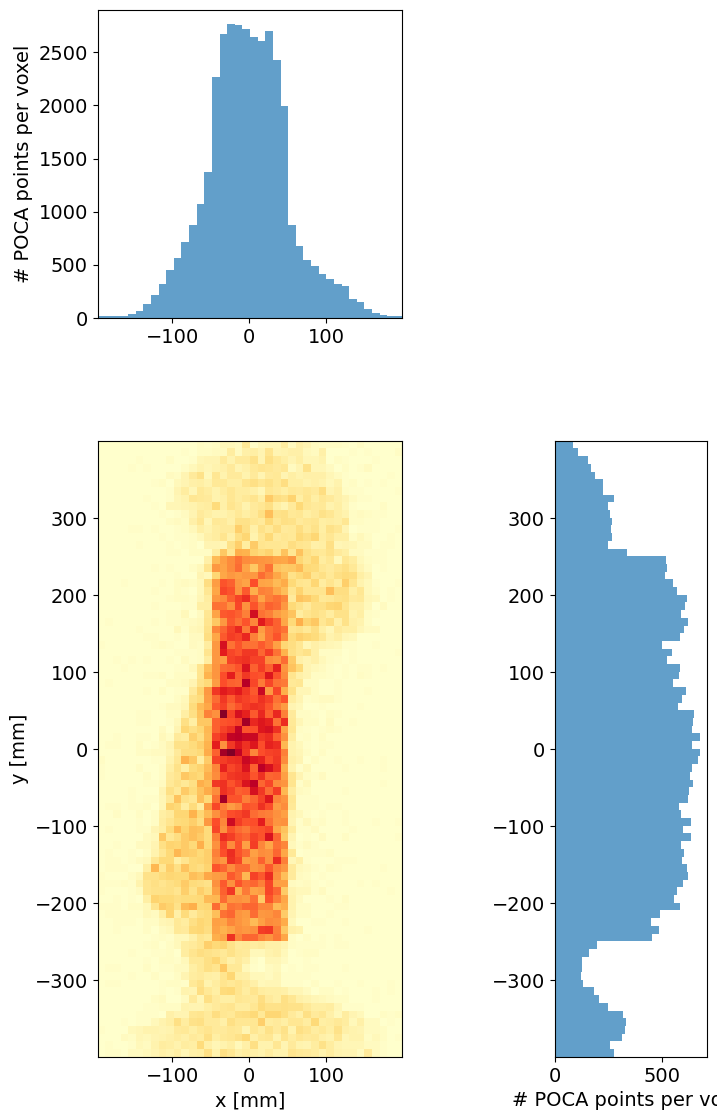

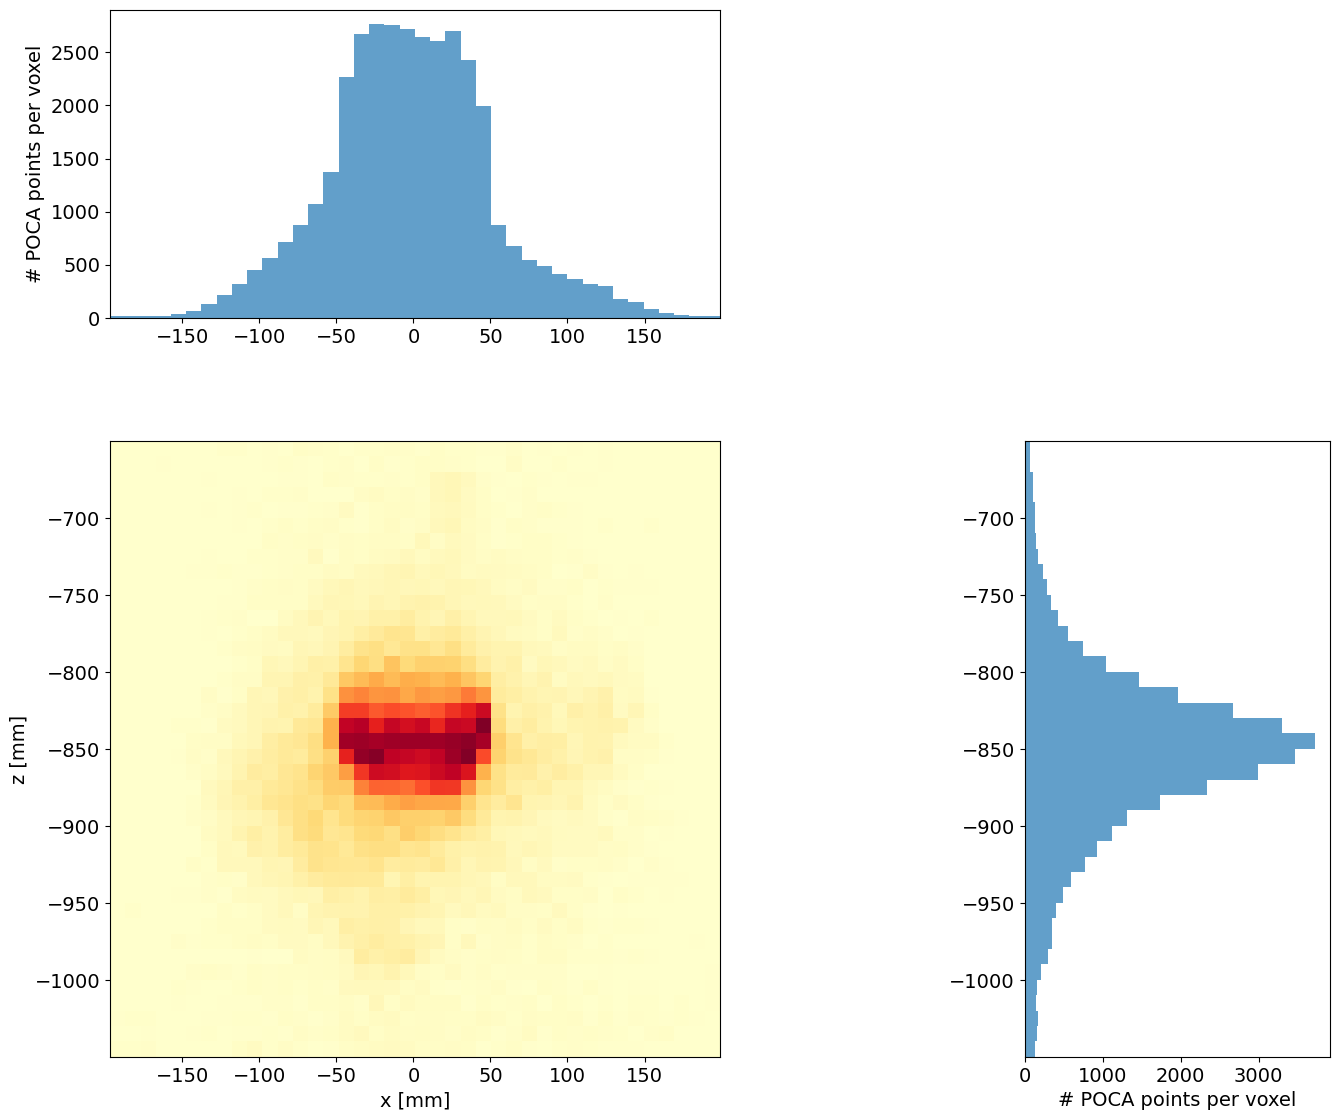

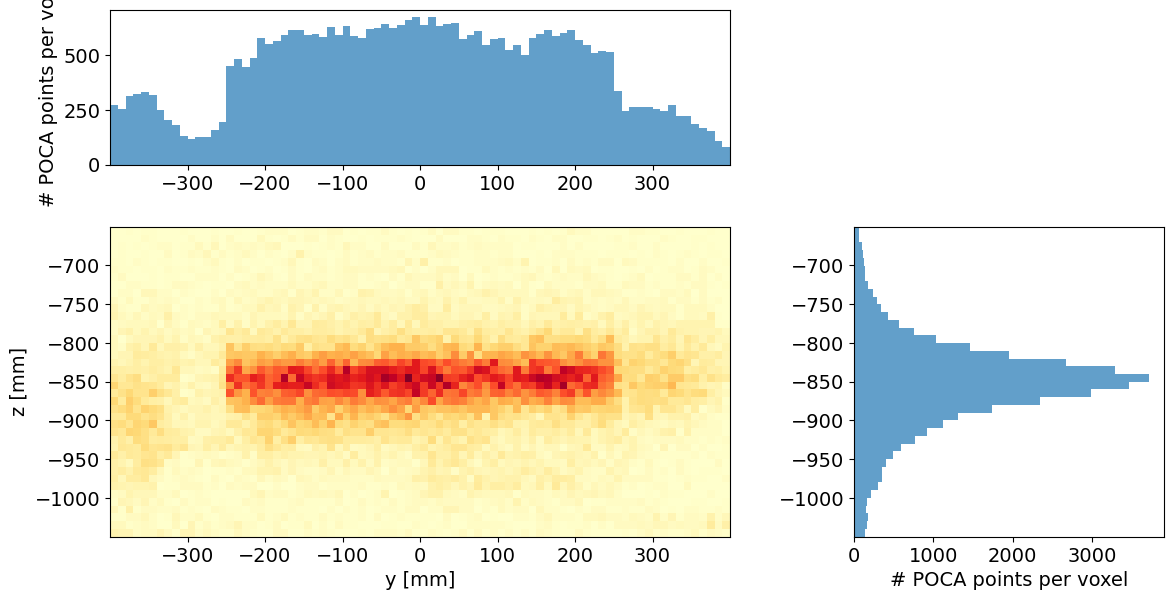

In [54]:
# PLot poca points location
from plotting.plotting import plot_POCA_points_multi_projection
plot_POCA_points_multi_projection(poca.poca_points,poca.mask_in_voi,binning_xyz=voi.n_vox_xyz)

In [55]:
%matplotlib qt
from plotting.plotting import plot_poca_3D_cloud
plot_poca_3D_cloud(poca, #Instance of the POCA class
                   poca.mask_in_voi, #keep only POCA points inside the Volume of interest
                   alpha=.01) # set point transparancy

In [56]:
%matplotlib qt
from plotting.plotting import plot_poca_3D_cloud
plot_poca_3D_cloud(poca,
                   poca.mask_in_voi & (poca.tracks.dtheta*180/math.pi>3),#keep only POCA points inside the Volume of interest & with dtheta>3 deg
                   alpha=.1)

# <center> Tutorial 3: POCA scattering density algorithm

The POCA scattering density algorithm is described in slides 31-32. Once POCA points are computed, we can create our first POCA-based reconstruction algorithm. We will start with a straight-forward implementation, where the score $s(d\theta,p)$ is simply $d\theta$:

**Before the scan:**

 - Create a voxelized volume of interest with a total number of voxels $N = N_x\times N_y \times N_z$
 - Associate an empty list $L_{i,j,k}$ to each voxel $V_{i,j,k}$

**Scan**:

`for` each event `e`:

 - Compute the POCA point location $P_{e} = \left(x_e,y_e,z_e\right)$
 - Compute the associated scattering angle $d\theta_{e}$
 - Find the *triggered* voxel $V_{i,j,k}$ (the voxel which contains the POCA point).
 - Append $d\theta_{e}$ to the triggered voxel score list $L_{i,j,k}$

**At the end of the scan**:

`for` each voxel $V_{i,j,k}$:

 - Compute $S_{i,j,k}$, the final score of $V_{i,j,k}$ as a function of $L_{i,j,k}$. In this example, we are using the quratile function such that the final score is equal to the desired quartile of the distribution, but other functions can be used (e.g `rms`, `np.mean`).
 - Compute $N_{\text{hit}}$, the number of POCA points per voxel.

For more details, you can check the exact implementation in the `muograph/reconstruction/poca.py` file.

In [57]:
# reject events with dtheta>10 deg and dtheta<1 deg
mask = (poca.tracks.dtheta<15*math.pi/180) 

from functools import partial

def rms(x)->float:
    x = np.array(x)
    return np.sqrt(np.mean(x**2))


# run the reconstruction
scores,hit_per_voxel = poca.poca_reconstruction(score_feature=poca.tracks.dtheta, # the scores to apply to the voxels 
                                                mask=mask, # the cuts
                                                score_method = partial(np.quantile,q=.9)) # the function to extract the final score.
                                                # score_method = partial(rms)) # the function to extract the final score.
                                                # score_method = partial(np.mean)) # the function to extract the final score.


## Plotting POCA scores

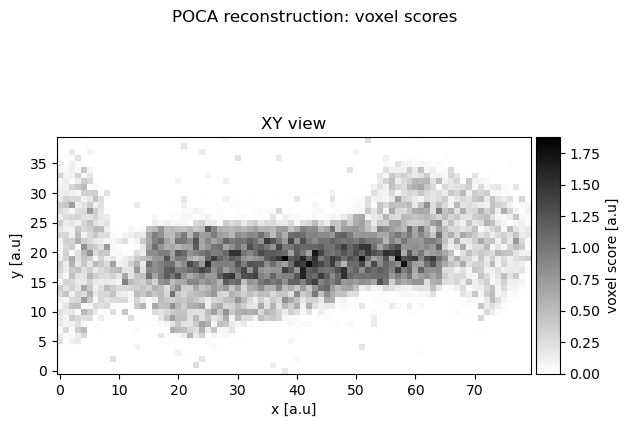

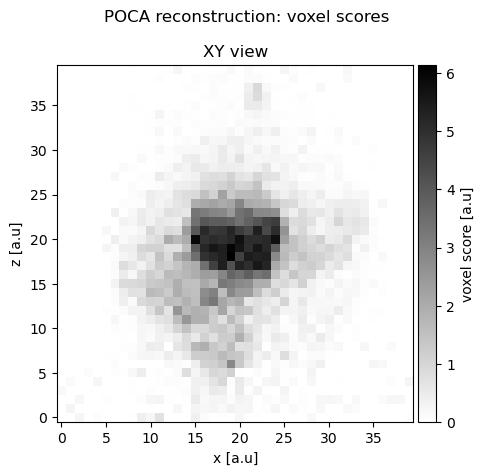

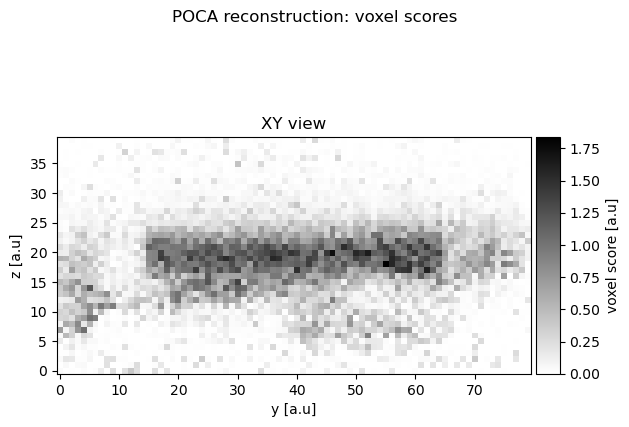

In [58]:
%matplotlib inline
from plotting.plotting import plot_poca_summary
plot_poca_summary(scores = scores)

# Plotting POCA points per voxel

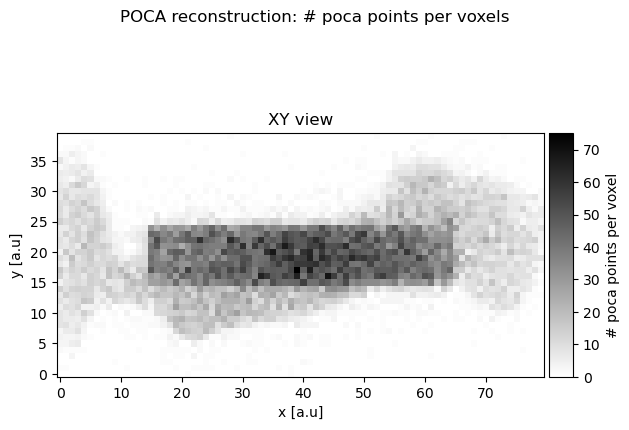

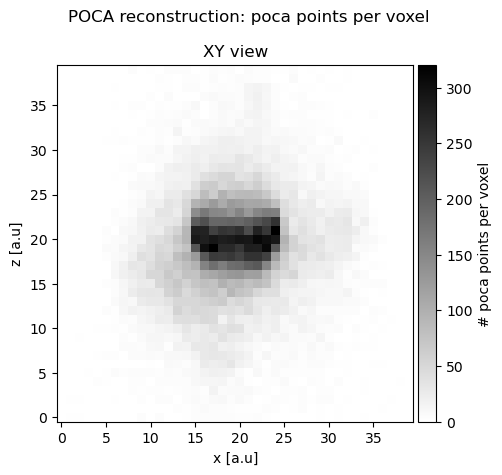

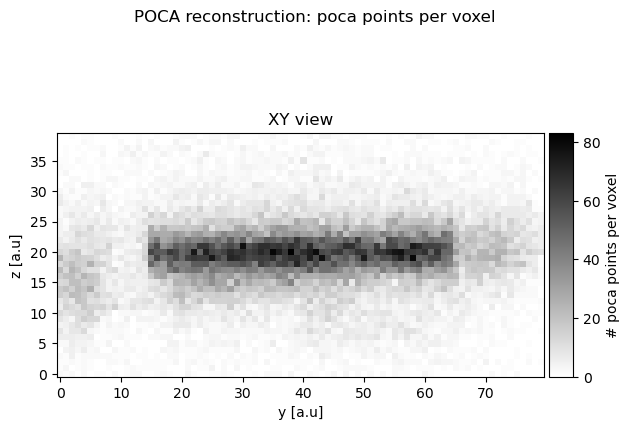

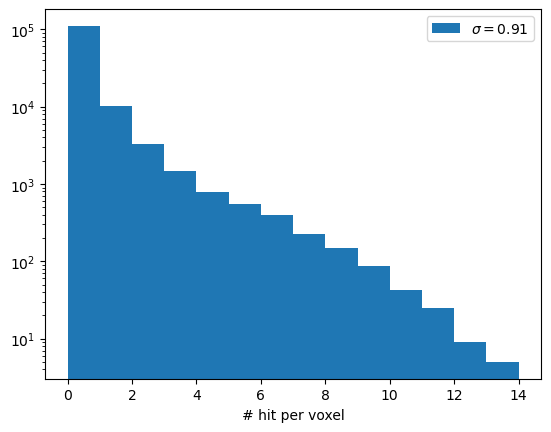

In [59]:
%matplotlib inline
from plotting.plotting import plot_poca_points_summary
plot_poca_points_summary(hit_per_voxel = hit_per_voxel)